<a href="https://colab.research.google.com/github/uygishypr/Technical_Project/blob/master/Colab_August_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dropout
from numpy import mean, nanargmin
from numpy import std
from matplotlib import pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import cv


In [19]:
df_merged_sorted = pd.read_excel("Nans_removed_dataset.xlsx", index_col =  [0, 1])
companies_list = df_merged_sorted.index.get_level_values('Company Name').unique().tolist()
print(companies_list)

['1-800-Flowers.Com Inc', '11 88 0 Solutions AG', '111 Inc', '17 Education & Technology Group Inc', '22nd Century Group Inc', '2G Energy AG', '2U Inc', '3M Co', '3P Learning Ltd', '5N Plus Inc', '888 Holdings PLC', 'A G Barr PLC', 'A O Smith Corp', 'A and W Revenue Royalties Income Fund', 'A2 Milk Company Ltd', 'A2B Australia Ltd', 'AAC Clyde Space AB', 'AAK AB (publ)', 'AAPICO Hitech PCL', 'AAR Corp', 'ABC Technologies Holdings Inc', 'ABC-Mart Inc', 'ABM Industries Inc', 'ACC Ltd', 'ACCO Brands Corp', 'ACS Actividades de Construccion y Servicios SA', 'ADAMA Ltd', 'ADT Inc', 'AECC Aviation Power Co Ltd', 'AECI Ltd', 'AECOM', 'AG Anadolu Grubu Holding AS', 'AGC Inc', 'AGCO Corp', 'AIA Engineering Ltd', 'AIC Mines Ltd', 'AK Alrosa PAO', 'AKR Corporindo Tbk PT', 'ALAFCO Avaiation Lease and Finance Co KSCP', 'ALD SA', 'ALS Ltd', 'AMA Group Ltd', 'AMETEK Inc', 'AMG Advanced Metallurgical Group NV', 'ANA Holdings Inc', 'ANTA Sports Products Ltd', 'AO World PLC', 'AP Moeller - Maersk A/S', 'A

In [20]:
# Check the number of missing values before filling
df_merged_sorted.isna().sum()
columns_list = list(df_merged_sorted.drop(columns=['Sum','Label','Identifier (RIC)']))
df_list = []

In [ ]:
for company in companies_list:

    subset_df = df_merged_sorted.loc[company].bfill(axis = "rows")
    df_list.append(subset_df)

vertical_concat = pd.concat(df_list, axis=0)
vertical_concat.isna().sum() 

In [23]:
vertical_concat_features = vertical_concat.iloc[:,0:56]

vertical_concat_features.drop(columns = ["Identifier (RIC)"],inplace = True)

In [27]:
vertical_concat_features = pd.get_dummies(vertical_concat_features, columns=["GICS Sector Name"], prefix=["Sector"])

In [41]:
X = np.array(vertical_concat_features)
y = np.array(vertical_concat["Label"])

In [28]:

X = np.array(vertical_concat_features)
y = np.array(vertical_concat["Label"])

X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X, y, 
                                   test_size=0.20,random_state=42, stratify=y)

impute_knn = KNNImputer(n_neighbors=1)
X_train_knn_imputed = impute_knn.fit_transform(X_train_knn)
X_test_knn_imputed = impute_knn.fit_transform(X_test_knn)


In [43]:
def select_features(X_train, y_train, X_test):
	fs = SelectKBest(score_func=chi2, k=30)
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs


X_train_fs, X_test_fs, fs = select_features(X_train_knn_imputed, y_train_knn, X_test_knn_imputed)

In [44]:
X_train_fs.shape

(22918, 30)

In [29]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12025068278864800442
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16139419648
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5878013782945038011
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


In [30]:
import tensorflow as tf
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [31]:
X_train_knn_imputed.shape

(22918, 59)

In [46]:
from sklearn.preprocessing import LabelEncoder
from keras import metrics

with tf.device("/device:GPU:0"):

  # create model
	model = Sequential()
	model.add(Dense(30, input_dim=30, activation='relu'))
	model.add(Dropout(0.2))
	model.add(Dense(15, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[metrics.AUC(),
																																	metrics.Precision(),
																																	metrics.Recall()]) 
 

	history = model.fit(
		X_train_fs,
    y_train_knn,
    batch_size = 64,
    epochs=100,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_test_fs, y_test_knn),
)



Epoch 1/100
359/359 [==============================] - 3s 6ms/step - loss: 0.4257 - auc_3: 0.5392 - precision_3: 0.1577 - recall_3: 0.0149 - val_loss: 0.3556 - val_auc_3: 0.6965 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/100
359/359 [==============================] - 2s 5ms/step - loss: 0.3671 - auc_3: 0.6739 - precision_3: 0.5714 - recall_3: 0.0014 - val_loss: 0.3460 - val_auc_3: 0.7248 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 3/100
359/359 [==============================] - 2s 5ms/step - loss: 0.3597 - auc_3: 0.6921 - precision_3: 0.4000 - recall_3: 6.7912e-04 - val_loss: 0.3436 - val_auc_3: 0.7329 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 4/100
359/359 [==============================] - 2s 5ms/step - loss: 0.3556 - auc_3: 0.7018 - precision_3: 0.5500 - recall_3: 0.0037 - val_loss: 0.3415 - val_auc_3: 0.7355 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 5/100
359/359 [==============================] - 2

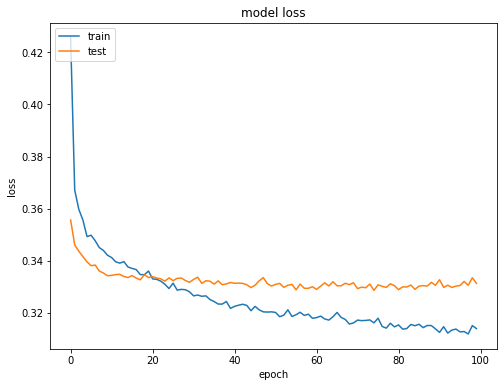

In [47]:
plt.figure(figsize = (8,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()